# FEDERATED LEARNING

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadr
import numpy as np

# Collect data

Dataset documentation : "https://cas.uqam.ca/pub/web/CASdatasets-manual.pdf"

Here, we concentrate on 3 different datasets on Motor Insurers : 
- `freMPL` (*French Motor Personal Line datasets*): This collection of ten datasets comes from a private motor French insurer. Each dataset includes risk features, claim amount and claim history of around 30,000 policies for year 2004. We decided to concacenate the differents freMPL datasets to focus on statistics.
- `beMTPL16` (*Belgian motor third-part liability dataset*): The dataset beMTPL was collected by an unknown Belgium insurer. It consists of 70 791 claims for private motor insurance.
- `euMTPL` (*European motor TPL insurance*): The euMTPL compiles three years of experience from a European MTPL (Motor Third Party Liability) portfolio, including frequency and severity values for different types of losses. The data was collected during the first decade of the 21st century.

In [2]:
# Change the paths to the location of the data on your machine
fre_path="/Users/nayelbenabdesadok/Documents/GitHub/Federated_Learning_Milliman/data_comparaison/freMPL.csv"
be_path="/Users/nayelbenabdesadok/Documents/GitHub/Federated_Learning_Milliman/data_comparaison/beMTPL97.rda"
eu_path="/Users/nayelbenabdesadok/Documents/GitHub/Federated_Learning_Milliman/data_comparaison/euMTPL.rda"
file_paths = [be_path, eu_path]

In [3]:
def load_rda(file_paths):
  dataframes = {}
  for file_path in file_paths:
      result = pyreadr.read_r(file_path)
      for key in result.keys():
          dataframes[key] = result[key]
  return dataframes

In [4]:
df_fre=pd.read_csv(fre_path)

In [5]:
df_0 = load_rda(file_paths)
dataframes = {
    "French": df_fre,
    "Belgium": df_0["beMTPL97"],
    "European": df_0["euMTPL"]
}

In [6]:
print("French columns:", dataframes["French"].columns)
print("Belgium columns:", dataframes["Belgium"].columns)
print("European columns:", dataframes["European"].columns)


French columns: Index(['Exposure', 'LicAge', 'RecordBeg', 'Gender', 'MariStat', 'SocioCateg',
       'VehUsage', 'DrivAge', 'HasKmLimit', 'BonusMalus', 'ClaimAmount',
       'ClaimInd'],
      dtype='object')
Belgium columns: Index(['id', 'expo', 'claim', 'nclaims', 'amount', 'average', 'coverage',
       'ageph', 'sex', 'bm', 'power', 'agec', 'fuel', 'use', 'fleet',
       'postcode', 'long', 'lat'],
      dtype='object')
European columns: Index(['policy_id', 'group', 'fuel_type', 'year', 'vehicle_category',
       'vehicle_use', 'province', 'horsepower', 'gender', 'age', 'exposure',
       'cost_nc', 'num_nc', 'cost_cg', 'num_cg', 'cost_fcg', 'num_fcg',
       'cost_cd', 'num_cd'],
      dtype='object')


In [7]:
print("French columns:", np.shape(dataframes["French"]))
print("be columns:", np.shape(dataframes["Belgium"]))
print("eu columns:", np.shape(dataframes["European"]))


French columns: (243065, 12)
be columns: (163212, 18)
eu columns: (2373197, 19)


In [8]:
dataframes["European"]["cost_claim"] = dataframes["European"]["cost_nc"] + dataframes["European"]["cost_cg"] + dataframes["European"]["cost_fcg"] + dataframes["European"]["cost_cd"] 


In [9]:
dataframes["European"]["cost_claim"].describe()

count    2.373197e+06
mean     3.058943e+02
std      4.005364e+03
min     -1.034309e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.452709e+06
Name: cost_claim, dtype: float64

# Choice of the variables to compare & Data Cleaning

Since the datasets are not identical, we need to select a common variable that will serve as the basis for comparison.
The target target variables are : 
- `Exposure` (*French :*`Exposure`, *Belgium :*`expo`, *European :*`exposure`): a numeric time of exposure, in years. -- **integer**
- `DriverAge` (*French :*`DrivAge`, *Belgium :*`ageph`, *European :*`age`): age of the driver -- **integer**
- `Gender` (*French :*`Gender`, *Belgium :*`sex`, *European :*`gender`): gender of the driver -- **{Male: 0,Female: 1}**
- `VehiculeUsage` (*French :*`VehUsage`, *Belgium :*`use`, *European :*`vehicle_use`): age of the driver -- **integer**
- `ClaimAmout` (*French :*`ClaimAmount`, *Belgium :*``, *European :*`cost_...`(differnt variables)):Total claim amount of the guarantee -- **real number**. For the european dataset, We will sum all the different `cost`variables to agregate all the sinisters.

Since the datasets have different variables, it is challenging to compare them accurately. Moreover, the French database had to be concatenated, and some variables had to be removed, for example.

In [10]:
french_data = dataframes["French"].rename(columns={
    'Exposure': 'Exposure',
    'DrivAge': 'DriverAge',
    'Gender': 'Gender',
    'VehUsage': 'VehiculeUsage',
    'ClaimAmount': 'ClaimAmount'
})[['Exposure', 'DriverAge', 'Gender', 'VehiculeUsage', 'ClaimAmount']]

belgium_data = dataframes["Belgium"].rename(columns={
    'expo': 'Exposure',
    'ageph': 'DriverAge',
    'sex': 'Gender',
    'use': 'VehiculeUsage',
    'amount': 'ClaimAmount'
})[['Exposure', 'DriverAge', 'Gender', 'VehiculeUsage', 'ClaimAmount']]

european_data = dataframes["European"].rename(columns={
    'exposure': 'Exposure',
    'age': 'DriverAge',
    'gender': 'Gender',
    'vehicle_use': 'VehiculeUsage',
    'cost_claim': 'ClaimAmount'
})[['Exposure', 'DriverAge', 'Gender', 'VehiculeUsage', 'ClaimAmount']]


### Sample the European data to approximize the size of the French and Belgium data

In [11]:
reduction_factor = 10
sample_size = len(european_data) // reduction_factor
european_data = european_data.sample(sample_size)

french_size = len(french_data)
belgium_size = len(belgium_data)
european_size = len(european_data)

total_size = french_size + belgium_size + european_size

french_proportion = 100 * (french_size / total_size)
belgium_proportion = 100 * (belgium_size / total_size)
european_proportion = 100 * (european_size / total_size)

print("French Proportion :", round(french_proportion, 2), "%")
print("Belgium Proportion :", round(belgium_proportion, 2), "%")
print("European Proportion :", round(european_proportion, 2), "%")


French Proportion : 37.77 %
Belgium Proportion : 25.36 %
European Proportion : 36.87 %


In [43]:
french_data['Sinistre'] = (french_data['ClaimAmount'] > 0).astype(int)
belgium_data['Sinistre'] = (belgium_data['ClaimAmount'] > 0).astype(int)
european_data['Sinistre'] = (european_data['ClaimAmount'] > 0).astype(int)

french_data['Gender'] = french_data['Gender'].replace({'Female': 1, 'Male': 0})
belgium_data['Gender'] = belgium_data['Gender'].replace({'female': 1, 'male': 0})
european_data['Gender'] = european_data['Gender'].replace({'F': 1, 'M': 0})


french_data['Dataset'] = 'french'
belgium_data['Dataset'] = 'belgium'
european_data['Dataset'] = 'european'

df_combined=pd.concat([french_data, belgium_data, european_data])


/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_45055/2721620741.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  belgium_data['Gender'] = belgium_data['Gender'].replace({'female': 1, 'male': 0})
/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_45055/2721620741.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  belgium_data['Gender'] = belgium_data['Gender'].replace({'female': 1, 'male': 0})
/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_45055/2721620741.py:7: FutureWarning: Downcasting behavior in `replace` is

In [46]:
### Sinistre par dataset

In [47]:
df_claim = df_combined.groupby(['Dataset', 'Sinistre']).size().reset_index(name='Count')
df_claim['Proportion'] = df_claim.groupby('Dataset')['Count'].transform(lambda x: x / x.sum())

/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_45055/1239152887.py:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(data=df_claim, x='Dataset', y='Proportion', hue='Sinistre', palette=palette, edgecolor='.3', linewidth=.8)


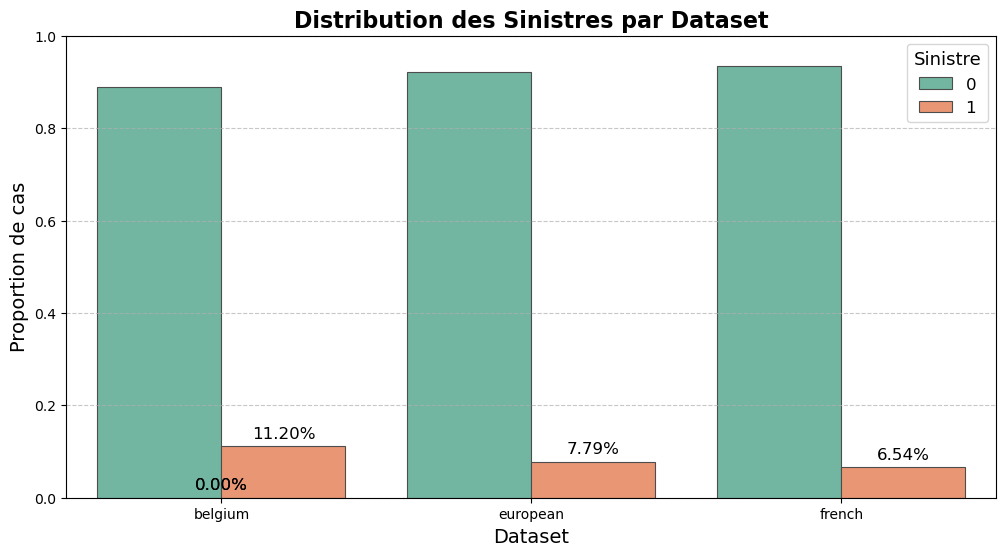

In [37]:
palette = sns.color_palette("Set2")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_claim, x='Dataset', y='Proportion', hue='Sinistre', palette=palette, edgecolor='.3', linewidth=.8)
plt.title('Distribution des Sinistres par Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Proportion de cas', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2%}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 9),
                       textcoords='offset points',
                       fontsize=12,
                       color='white' if p.get_height() > 0.5 else 'black')

plt.legend(title='Sinistre', title_fontsize='13', fontsize='12', loc='upper right')

plt.show()

### Proportion de Sinistres par Âge du Conducteur (DriverAge)

/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_45055/2005202093.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.lineplot(data=df_age_proportions, x='DriverAge', y='Proportion', hue='Dataset', style='Sinistre', markers=True, palette=palette)


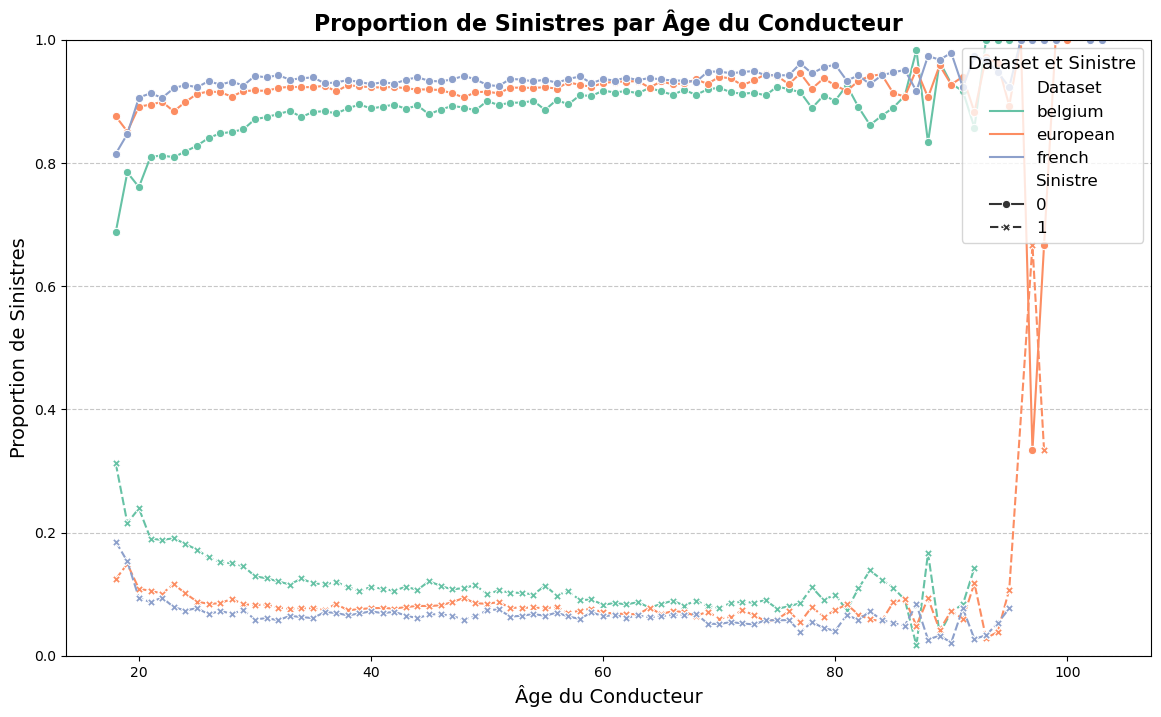

In [38]:
df_age_proportions = df_combined.groupby(['Dataset', 'DriverAge', 'Sinistre']).size().reset_index(name='Count')
df_age_proportions['Proportion'] = df_age_proportions.groupby(['Dataset', 'DriverAge'])['Count'].transform(lambda x: x / x.sum())

palette = sns.color_palette("Set2")

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_age_proportions, x='DriverAge', y='Proportion', hue='Dataset', style='Sinistre', markers=True, palette=palette)
plt.title('Proportion de Sinistres par Âge du Conducteur', fontsize=16, fontweight='bold')
plt.xlabel('Âge du Conducteur', fontsize=14)
plt.ylabel('Proportion de Sinistres', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(title='Dataset et Sinistre', title_fontsize='13', fontsize='12', loc='upper right')

plt.show()

### Sinistres par Genre (Gender)

/var/folders/sg/lshv0q7145ggm8z9kc3b1y4r0000gn/T/ipykernel_45055/4101260678.py:9: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=df_gender_proportions, x='Gender', y='Proportion', hue='Dataset', palette=palette, edgecolor='.3', linewidth=.8)


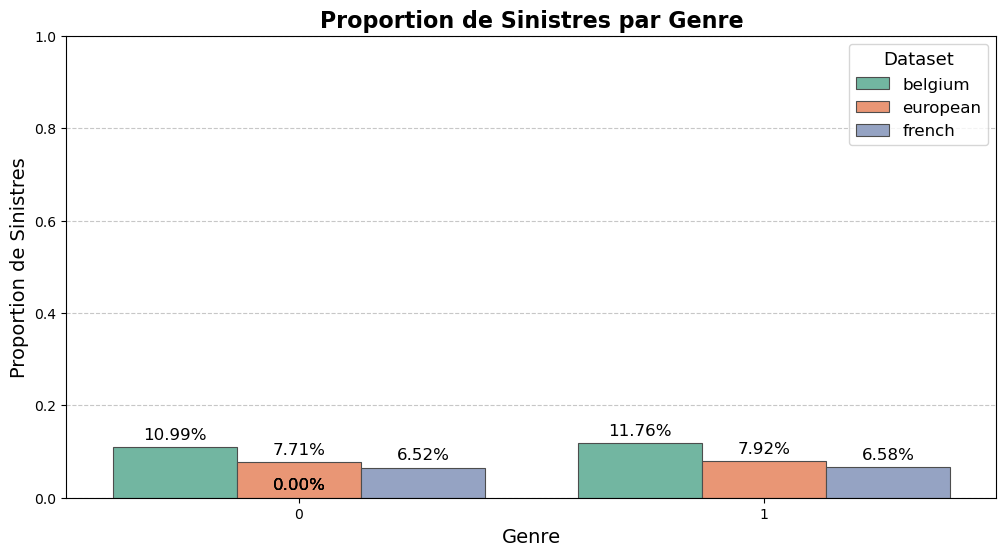

In [49]:
df_gender_proportions = df_combined.groupby(['Dataset', 'Gender', 'Sinistre']).size().reset_index(name='Count')
df_gender_proportions['Proportion'] = df_gender_proportions.groupby(['Dataset', 'Gender'])['Count'].transform(lambda x: x / x.sum())

df_gender_proportions = df_gender_proportions[df_gender_proportions['Sinistre'] == 1]

palette = sns.color_palette("Set2")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_gender_proportions, x='Gender', y='Proportion', hue='Dataset', palette=palette, edgecolor='.3', linewidth=.8)
plt.title('Proportion de Sinistres par Genre', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Proportion de Sinistres', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2%}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 9),
                       textcoords='offset points',
                       fontsize=12,
                       color='white' if p.get_height() > 0.5 else 'black')

plt.legend(title='Dataset', title_fontsize='13', fontsize='12', loc='upper right')

plt.show()

In [14]:
french_data["VehiculeUsage"]

0                   Professional
1         Private+trip to office
2                   Professional
3                   Professional
4                   Professional
                   ...          
243060              Professional
243061                   Private
243062                   Private
243063                   Private
243064    Private+trip to office
Name: VehiculeUsage, Length: 243065, dtype: object

In [15]:
belgium_data.describe()

,Exposure,DriverAge,ClaimAmount
count,163212.000000,163212.000000,163212.000000
mean,0.889744,47.000950,162.150883
std,0.244202,14.831561,1374.575776
min,0.002740,18.000000,0.000000
25%,1.000000,35.000000,0.000000
50%,1.000000,46.000000,0.000000
75%,1.000000,58.000000,0.000000
max,1.000000,95.000000,140032.424473


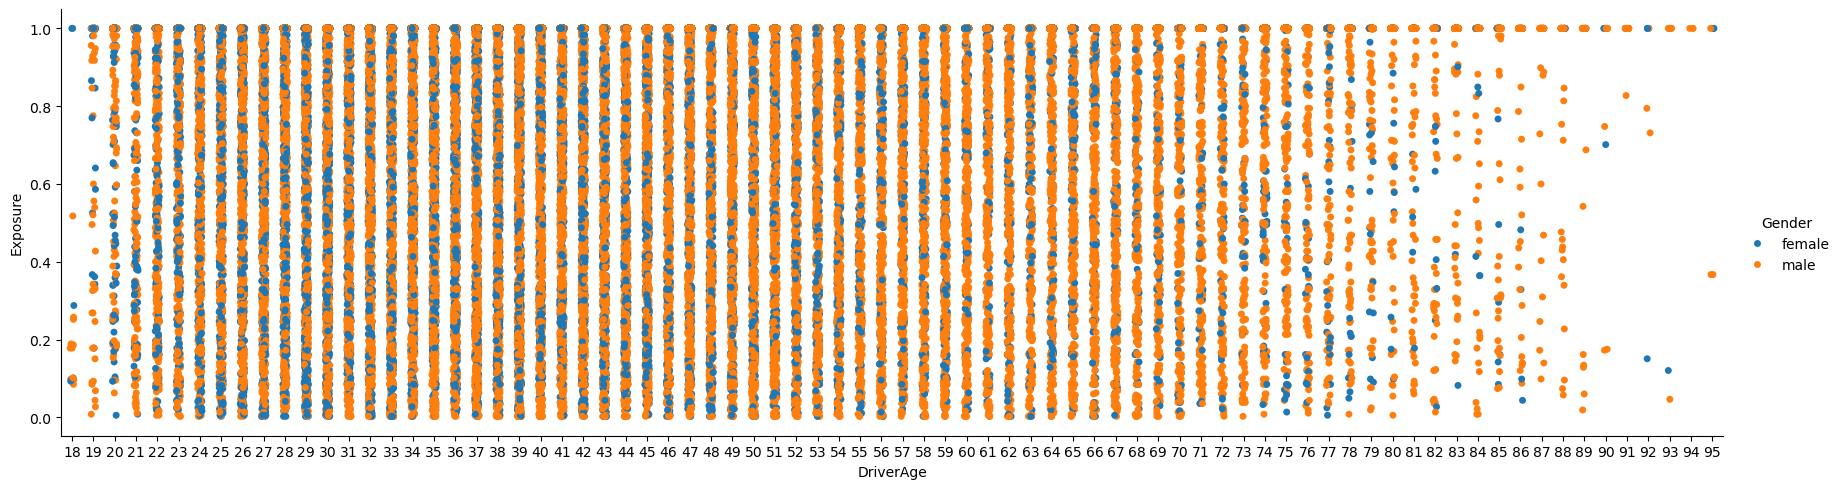

In [16]:
sns.catplot(data=belgium_data, x="DriverAge", y="Exposure",hue="Gender",aspect=3.5)

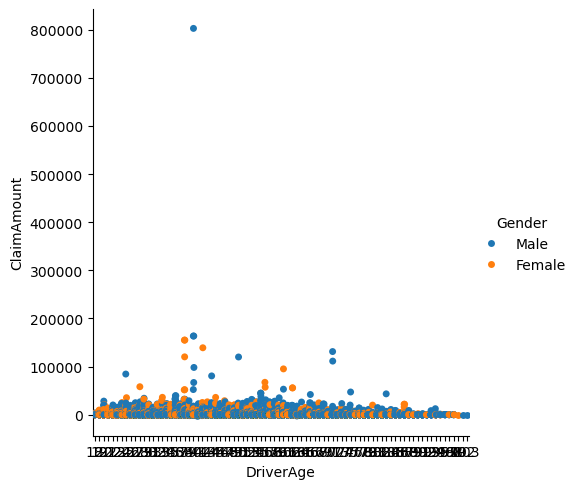

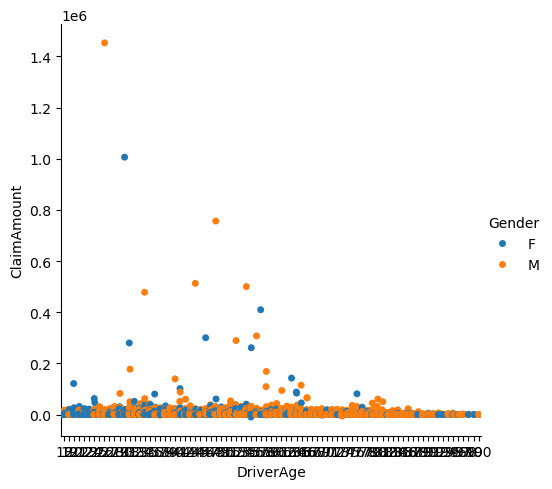

In [17]:
sns.catplot(data=french_data, x="DriverAge", y="ClaimAmount",hue="Gender")
sns.catplot(data=european_data, x="DriverAge", y="ClaimAmount",hue="Gender")


In [18]:
def missing_values(df):
  return(df.isnull().sum())

In [19]:
def outlier_values(df):
    outliers = pd.Series(dtype="float64")

    for col in df.select_dtypes(include=["number"]):  
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        mask = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
        outliers[col] = mask.mean() * 100  
    return outliers